## Creating a multiclassifier paddy disease model

From WT 12, 12min. We will work on how to predict both the disease and rice type. Inuitively this seems it will reduce model accuracy to predict disease but JH has pointed out that this is not alwasya the case. 

Plus it seems a great exercise to adapt a pytprch/fastAI model and api to a different problem and understand the nternal of several classes. 

In [1]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
!pip install -Uq --user 'timm==0.6.2.dev0'
!pip install fastai 'fastai>2.7.10'
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'
from fastai.vision.all import *

In [2]:
timm.__version__

'0.6.2.dev0'

In [3]:
# paperspace runs diff version sof fastai for diff GPUs
# its really annoying
import fastai
fastai.__version__

'2.7.14'

In [4]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')
train_images = path / 'train_images'
test_images = path / 'test_images'
test_images_files = get_image_files(test_images).sorted()
    

In [5]:
path.ls()

(#5) [Path('/notebooks/paddy/data/sample_submission.csv'),Path('/notebooks/paddy/data/test_images'),Path('/notebooks/paddy/data/train_images'),Path('/notebooks/paddy/data/train.csv'),Path('/notebooks/paddy/data/paddy-disease-classification.zip')]

In [6]:
try: df = pd.read_csv(path/'train.csv')
except FileNotFoundError:
    !paddy/get_data.sh
    df = pd.read_csv(path/'train.csv')

In [7]:
# looking at variety
df['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

## Lets delve into a model

First lets get a sense of the error rate. By traiing for three epochs on the same dl (seed) does the model present a big variation across epochs. If the natural variation is too big that will be trough to train. It could be the case that the learning rate is too big or the data is not good enough to create a model. 

Also jeremy point on use smaller models to get a sense on how good the archeteture will do for the problem at hand. Meaning if convnext tine does a good job likely convenext large with same transforms and resizes will do great. We can see for the below the variation has been small. 

In [8]:
timm.list_models(filter='convnext*')

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano_hnf',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_hnfd',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [9]:
arch = 'convnext_tiny_in22k'
dls = ImageDataLoaders.from_folder(
    train_images, seed=42, valid_pct=.2, 
    item_tfms=Resize(480), batch_tfms=aug_transforms(size=224, min_scale=.75)
)

In [10]:
# learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
# learn.fine_tune(3, 0.01)

In [11]:
# learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
# learn.fine_tune(3, 0.02)

In [12]:
# learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
# learn.fine_tune(3, 0.02)

In [13]:
# learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
# learn.fine_tune(3, 0.02)

## Looking inside the model 

Timm body and the head. Body does the hard work. it's the bon nn. In the very end it spits out a bunch of info about the pixels. The head makes sense of the predictions to look at. The head is pretty simple usually compared with the body. We want to predict 2 things. rice type and disease. Head part is below.  Linear layer is something that makes a matrix product. 

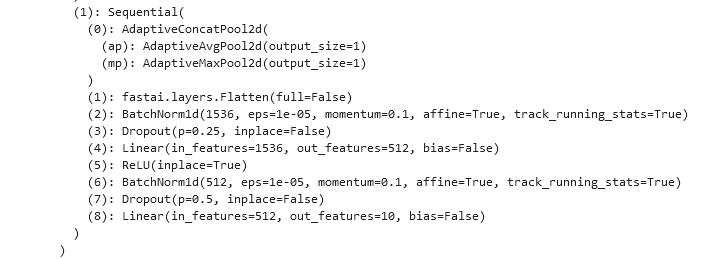

In [14]:
learn = vision_learner(dls, arch, metrics=error_rate)
m = learn.model
m


Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=96, out_features=384, bias=True)
                (act): GELU(approximate=none)
                (drop1): Dropout(p=0.0, inplace=False)
                (fc2): Linear(in_features=384, out_features=96, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
            )
            (1): ConvNeXtBlock(
              (conv_

In [15]:
#  great trick to see shapes through out model
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 56 x 56   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     64 x 56 x 56 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 56 x 56 x 96   
Linear                                    36960      False     
Dropout                            

In [16]:
# get the head
h = m[1]
h

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [17]:
# last layer -> end of the head
ll = h[-1]

In [18]:
# looking at the params of the ll
llp = list(ll.parameters())[0]

In [19]:
llp

Parameter containing:
tensor([[ 0.0383,  0.0801,  0.0871,  ..., -0.1087,  0.0373,  0.0065],
        [-0.0052, -0.0366, -0.0800,  ..., -0.0251,  0.0224, -0.0012],
        [ 0.0699, -0.0442, -0.0349,  ...,  0.0112,  0.0412, -0.0420],
        ...,
        [-0.0225, -0.0111,  0.0350,  ..., -0.0813,  0.0185, -0.0395],
        [-0.0300,  0.0362, -0.0147,  ...,  0.0790,  0.1494,  0.0255],
        [ 0.0031, -0.0612,  0.1150,  ...,  0.0554,  0.0975,  0.0259]],
       device='cuda:0', requires_grad=True)

In [20]:
# transposed but we get the last matrix input not the output. 
llp.shape

torch.Size([10, 512])

In [21]:
# delete last element of sequential 
del(h[-1])

In [22]:
# step 8 is gone
h

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1536, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
)

## Model plumbing

- the most difficult method according to Jeremy bu as said great exercise. 
- create a dummy classifier to test end to end

In [23]:
# lets create a class for plumbing testing only
class DummyClassifier(nn.Module):
    def __init__(self, m):
        super().__init__() # instantiate nn.Module model prior to my understanding
        self.m = m # wrap actual model
    def forward(self, x):
        x = self.m(x) # sequential call
        return x

In [24]:
from copy import deepcopy

learn = vision_learner(dls, arch, metrics=error_rate)
learn2 = deepcopy(learn) # deepcopy does not work for me NOTE: fastai.__version__ has to be > 2.7.9

In [25]:
# set the model to our new model
dtc = DummyClassifier(learn2.model)
learn2.model = dtc

In [26]:
# test preds to verify if the plumming is working
# err i whtink the (torch.cuda.HalfTensor) pointed jeremy to an erro with fp_16
# possibly a callback was happening so likely a kernel reset is required if running top down avoiding training and fp_16
preds, targs = learn2.get_preds(dl=learn2.dls.valid)

In [27]:
# output of ten probs as expect
preds.shape

torch.Size([2081, 10])

### Test new plumbing

WT12 from 47 min  starting to look into loss fns; it appears fastai versions will have to be bigger than 2.7.9 for code to work. deepcopy will not work and model will fail. "Sequential as no attibute dl" error will be shown

Good error is shown below: 

- AttributeError: 'tuple' object has no attribute 'view'. Good point model cannot calculate loss. need to define loss fn. The issue here is create as the loss fn expects a tensor and we return a tuple of tensor as per our class DandTClf.  Altoigh with loss is set to false the learner itself has a loss function attributed. If no loss function has been defined Learner class will attempt to retreive it from the train dataset dataloader. data loader contain loss function

According to jeremy by having the loss coming from the dataset we can have sensible defaults. one class predictions cross entropy, regression mse loss, multiclass log loss with no softmax. See WT 12 min 55

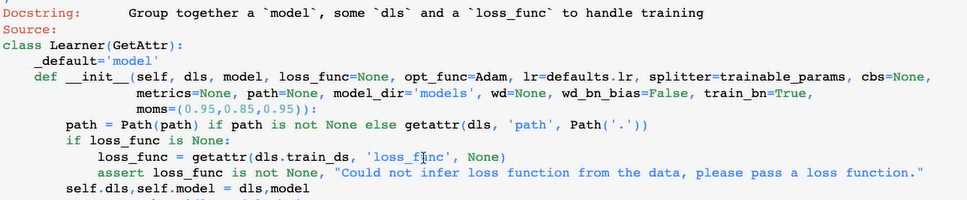 


In [28]:
?? Learner

Init signature:
 Learner(
    dls: 'DataLoaders',
    model: 'callable',
    loss_func: 'callable | None' = None,
    opt_func: 'Optimizer | OptimWrapper' = <function Adam at 0x7fa77500a670>,
    lr: 'float | slice' = 0.001,
    splitter: 'callable' = <function trainable_params at 0x7fa77761caf0>,
    cbs: 'Callback | MutableSequence | None' = None,
    metrics: 'callable | MutableSequence | None' = None,
    path: 'str | Path | None' = None,
    model_dir: 'str | Path' = 'models',
    wd: 'float | int | None' = None,
    wd_bn_bias: 'bool' = False,
    train_bn: 'bool' = True,
    moms: 'tuple' = (0.95, 0.85, 0.95),
    default_cbs: 'bool' = True,
)
Docstring:      Group together a `model`, some `dls` and a `loss_func` to handle training
Source:        
class Learner(GetAttr):
    _default='model'
    def __init__(self,
        dls:DataLoaders, # `DataLoaders` containing fastai or PyTorch `DataLoader`s
        model:callable, # PyTorch model for training or inference
        loss_func

In [29]:
dls.train_ds.loss_func

FlattenedLoss of CrossEntropyLoss()

In [30]:
arch

'convnext_tiny_in22k'

In [31]:
learn = vision_learner(dls, arch)# for now need to remove metrics JH  
learn2 = deepcopy(learn) # deepcopy does not work for me

# lets create a class to wrap the last layer of the head
# the least easy way 
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self, m):
        super().__init__() # instantiate model prior to my understanding
        self.l1 =  nn.Linear(in_features=512, out_features=10, bias=False) # rice type
        self.l2 =  nn.Linear(in_features=512, out_features=10, bias=False) # disease
        # move the head deletion steps here
        del(m[1][-1]) # delete the head last step
        self.m = m # wrap actual model
        
    def forward(self, x):
        x = self.m(x) # sequential call
        # 2 diff outputs
        x1 = self.l1(x)
        x2 = self.l2(x)
        return x1, x2

# set the model to our new model
dtc = DiseaseAndTypeClassifier(learn2.model)
learn2.model = dtc

In [32]:
learn2.loss_func

FlattenedLoss of CrossEntropyLoss()

In [33]:
preds, targs = learn2.get_preds(dl=learn2.dls.valid)

AttributeError: 'tuple' object has no attribute 'view'

### Loss function for multi clf


Based on above error we need to define the loss function of the model to hanlde tuples. For now just unpack model output and handle diseases only as per initial usage. JH appraoch is to tets the pumbling. 

In [34]:
learn = vision_learner(dls, arch)# for now need to remove metrics JH  
learn2 = deepcopy(learn) # deepcopy does not work for me

curr_loss = learn2.loss_func
# lets create a loss fn
# firs lets make it work on disease
def dtc_loss(preds, targs):
    # ignore rice targs preds just to make the plumbing work 
    rice_preds, dis_preds = preds
    return curr_loss(dis_preds, targs)

dtc = DiseaseAndTypeClassifier(learn2.model)
learn2.model = dtc
learn2.loss_func = dtc_loss

In [35]:
# lets look into loss fn
learn2.loss_func

<function __main__.dtc_loss(preds, targs)>

In [36]:
# throws error on cb,
preds, targs = learn2.get_preds(dl=learn2.dls.valid)

In [37]:
type(preds)

tuple

In [38]:
# split the predictions based on type
rice_preds, dis_preds = preds

In [39]:
dis_preds.shape

torch.Size([2081, 10])

### Metrics function for multi clf

As above lets make the plumbing work. 

In [40]:
def dtc_error(preds, targs):
    # ignore rice targs
    rice_preds, dis_preds = preds
    return error_rate(dis_preds, targs)

In [41]:
learn = vision_learner(dls, arch, metrics=error_rate)
learn2 = deepcopy(learn) # deepcopy does not work for me
dtc = DiseaseAndTypeClassifier(learn2.model)
learn2.model = dtc
learn2.loss_func = dtc_loss
learn2.metrics = [dtc_error]

In [42]:
preds, targs = learn2.get_preds(dl=learn2.dls.valid)

## Test baseline methods of Learner

- lr find
- fine tune

SuggestedLRs(valley=0.001737800776027143)

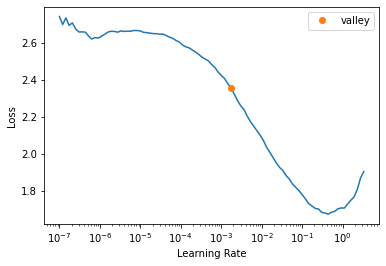

In [43]:
learn2.lr_find()

In [44]:
# suggested by JH valley start is too conservative. point beyond  with good slope usually best 10^-2
learn2.fine_tune(1, 0.01) 

epoch,train_loss,valid_loss,dtc_error,time
0,0.832710,0.522569,0.165786,01:08


epoch,train_loss,valid_loss,dtc_error,time
0,0.450183,0.304763,0.098991,03:51
